In [2]:
import pandas as pd
import numpy as np
import math

## Importing and Preprocessing Data

Vertiport Binary + Distance Matrix

In [71]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert coordinates from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 

    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371.0

    # Calculate the result
    return c * r

vertiport_connection = pd.read_csv('random_sets.csv').iloc[:125,:]
split = vertiport_connection['Numbers'].str.split(",")
vertiport_connection = np.zeros((125, 20))
for i in range(125):
    idx = np.array(split[i], dtype=int)-1
    vertiport_connection[i,idx] = 1
y = pd.read_csv('total_travel_time.csv')['total_travel_time'].to_numpy()
data_with_cluster_labels = pd.read_csv('data_with_cluster_labels.csv')
data_with_cluster_labels_nonull = data_with_cluster_labels[data_with_cluster_labels['cluster_label'].notna()]
data_with_cluster_labels_nonull_20 = data_with_cluster_labels_nonull[(data_with_cluster_labels_nonull['cluster_label'] <= 20) & (data_with_cluster_labels_nonull['cluster_label'] >= 1)]
# Calculate the mean of x and y for each cluster
data_with_cluster_labels_nonull_20_grouped = data_with_cluster_labels_nonull_20.groupby('cluster_label').agg({'x': 'mean', 'y': 'mean'}).reset_index()

# Rename columns
data_with_cluster_labels_nonull_20_grouped.columns = ['cluster_label', 'mean_x', 'mean_y']
vertiport_loc_dic = {}
for i in range(20):
    vertiport_loc_dic[i+1] = (data_with_cluster_labels_nonull_20_grouped['mean_x'][i], data_with_cluster_labels_nonull_20_grouped['mean_y'][i])
vertiport_network_before_reshape = np.zeros((125, 20, 20))
for i in range(125):
    for j in range(20):
        for k in range(20):
            if vertiport_connection[i, j] == 1 and vertiport_connection[i, k] == 1:
                vertiport_network_before_reshape[i, j, k] = haversine(vertiport_loc_dic[j+1][1], vertiport_loc_dic[j+1][0], vertiport_loc_dic[k+1][1], vertiport_loc_dic[k+1][0])
vertiport_network = vertiport_network_before_reshape.reshape(125, 400)
x = np.concatenate((vertiport_connection, vertiport_network), axis=1)


ImportError: cannot import name 'PCA' from 'sklearn' (/Users/Albert/opt/anaconda3/lib/python3.9/site-packages/sklearn/__init__.py)

In [84]:
x[:,20:].shape

(125, 400)

In [66]:
all = np.zeros(shape=(125,20,20))
all[np.where(x[:,20:].reshape(125,20,20) >= 6*1.6)] = 1

In [63]:
all = x[:,20:].reshape(125,20,20)

In [61]:
all.shape

(125, 20, 20)

In [69]:
def func(x):
    degree_matrix = np.diag(x.sum(axis=1))
    laplacian_matrix = degree_matrix - x
    eigenvalues = np.linalg.eigvals(laplacian_matrix)

    sorted_eigenvalues = np.sort(eigenvalues)
    second_smallest_eigenvalue = sorted_eigenvalues[1]

    return second_smallest_eigenvalue
smev = []
for i in range(125):
    smev.append(func(all[i,:,:]))



In [81]:
func(x[15,20:].reshape(20,20))

0.0

In [82]:
all

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 1., 1., 1.],
        [1., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 1., 1., ..., 1., 0., 1.],
        [1., 0., 1., ..., 1., 0., 1.],
        [1., 1., 0., ..., 1., 0., 1.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0.

Demand

In [3]:
demand = pd.read_csv('/Users/jiangxuan/Desktop/[00] Ongoing Research/[10] Regional Traffic Simulation/[07] Simulation Based Optimization/SBO/Proj/OD_UAM_Suitable.csv')
demand_with_origin_cluster = pd.merge(
    demand,
    data_with_cluster_labels_nonull_20[['osmid', 'cluster_label']],
    left_on='origin_osmid',
    right_on='osmid',
    how='left'
)
# Drop the duplicate 'osmid' column that resulted from the merge
demand_with_origin_cluster.drop('osmid', axis=1, inplace=True)

# Rename the 'cluster_label' column to 'origin_cluster_label'
demand_with_origin_cluster.rename(columns={'cluster_label': 'origin_cluster_label'}, inplace=True)

# Step 2: Merge on "destination_osmid"
demand_with_both_clusters = pd.merge(
    demand_with_origin_cluster,
    data_with_cluster_labels_nonull_20[['osmid', 'cluster_label']],
    left_on='destination_osmid',
    right_on='osmid',
    how='left'
)

# Drop the duplicate 'osmid' column that resulted from the merge
demand_with_both_clusters.drop('osmid', axis=1, inplace=True)

# Rename the 'cluster_label' column to 'destination_cluster_label'
demand_with_both_clusters.rename(columns={'cluster_label': 'destination_cluster_label'}, inplace=True)

# Drop rows where either "origin_cluster_label" or "destination_cluster_label" is NaN
demand_with_both_clusters = demand_with_both_clusters.dropna(subset=['origin_cluster_label', 'destination_cluster_label'])
demand_with_both_clusters = demand_with_both_clusters[demand_with_both_clusters['origin_cluster_label'] != demand_with_both_clusters['destination_cluster_label']]


# Step 1: Create a pivot table to count the occurrences of each combination of "origin_cluster_label" and "destination_cluster_label"
pivot_table = demand_with_both_clusters.pivot_table(
    index='origin_cluster_label',
    columns='destination_cluster_label',
    values='distance',
    aggfunc='count',
    fill_value=0
)

# Step 2: Reindex the pivot table to ensure it has a 20x20 shape
# (Note: If there are any missing cluster labels in the original data, the reindex will add them and fill with zeros.)
cluster_labels = range(1, 21)  # Assuming cluster labels range from 1 to 20
pivot_table = pivot_table.reindex(index=cluster_labels, columns=cluster_labels, fill_value=0)

# The resulting "pivot_table" is a 20x20 matrix where each cell (i, j) represents the count of occurrences from cluster i to cluster j.
demand_matrix = pivot_table.to_numpy()
vertiport_demand = np.zeros((125, 20, 20))
for i in range(125):
    # Create a new matrix by combining the values from "matrix" and "original_matrix"
    vertiport_demand[i] = np.where(vertiport_network_before_reshape[i] != 0, demand_matrix, 0)
vertiport_demand = vertiport_demand.reshape(125, 400)
x = np.concatenate((x, vertiport_demand), axis=1)

Road Type

In [4]:
edge = pd.read_csv('/Users/jiangxuan/Desktop/[00] Ongoing Research/[10] Regional Traffic Simulation/[07] Simulation Based Optimization/SBO/Proj/edges.csv')
node = pd.read_csv('/Users/jiangxuan/Desktop/[00] Ongoing Research/[10] Regional Traffic Simulation/[07] Simulation Based Optimization/SBO/Proj/nodes.csv')
edge_connected = pd.merge(
    edge,
    node,
    left_on='osmid_u',
    right_on='osmid',
    how='left'
)
import pandas as pd
import numpy as np

# Function to calculate Haversine distance between two points
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth's radius in km
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Create a new dataframe to store the results
result_df = pd.DataFrame(columns=["cluster_label", "edge_id", "distance", "length", "speed_mph"])

# Iterate through each row in the "data_with_cluster_labels_nonull_20_grouped" dataframe
for _, row in data_with_cluster_labels_nonull_20_grouped.iterrows():
    cluster_label = row["cluster_label"]
    mean_x = row["mean_x"]
    mean_y = row["mean_y"]

    # Calculate distance between the point in the current row and all edges in "edge_connected"
    edge_connected["distance"] = haversine_distance(mean_y, mean_x, edge_connected["y"], edge_connected["x"])

    # Sort edges based on distance and select the top 5 closest edges
    closest_edges = edge_connected.nsmallest(5, "distance")[["uniqueid", "distance", "length", "speed_mph"]]

    # Add the cluster_label to the closest_edges dataframe
    closest_edges["cluster_label"] = cluster_label

    # Concatenate the closest_edges dataframe with the result_df
    result_df = pd.concat([result_df, closest_edges])

# Reset the index of the result_df
result_df.reset_index(drop=True, inplace=True)

print(result_df)
length_matrix = np.zeros((20, 5))
speed_matrix = np.zeros((20, 5))
k = 0
for i in range(20):
    for j in range(5):
        length_matrix[i][j] = result_df['length'][k]
        speed_matrix[i][j] = result_df['speed_mph'][k]
        k = k + 1      
        
lengths_matrix = np.zeros((125, 20, 5))
speeds_matrix = np.zeros((125, 20, 5)) 
for i in range(125):
    for j in range(20):
        if (vertiport_connection[i][j] == 1):
            lengths_matrix[i][j] = length_matrix[j]
            speeds_matrix[i][j] = speed_matrix[j]

road_length = lengths_matrix.reshape(125, 100)
x = np.concatenate((x, road_length), axis=1)
road_speed = speeds_matrix.reshape(125, 100)
x = np.concatenate((x, road_speed), axis=1)


Data Split

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## RandomForest Regression

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
grid = {'n_estimators': [i for i in range(1,20)],
        'min_samples_split': [i for i in range(2,10)],
        'max_features' : [i for i in range(8, 20, 2)]}
cv_rf = GridSearchCV(estimator = RandomForestRegressor(), param_grid=grid, verbose=0, cv = 3, n_jobs = -1)
fitted = cv_rf.fit(x_train, y_train)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
sampled_yhat = fitted.best_estimator_.predict(x_test)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

sampled_yhat = fitted.best_estimator_.predict(x_test)
print('MAE: ', mean_absolute_error(y_test, sampled_yhat))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))
print('MAPE: ', mean_absolute_percentage_error(y_test, sampled_yhat))

# print('MAE: ', mean_absolute_error(y_test, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))

MAE:  1246463.0038911628
RMSE:  1377235.6886045188
MAPE:  0.05504093233312259


In [12]:
fitted.best_estimator_

RandomForestRegressor(max_features=18, min_samples_split=4, n_estimators=14)

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
sampled_yhat = fitted.best_estimator_.predict(x_test)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

sampled_yhat = fitted.best_estimator_.predict(x_test)
print('MAE: ', mean_absolute_error(y_test, sampled_yhat))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))
print('MAPE: ', mean_absolute_percentage_error(y_test, sampled_yhat))

# print('MAE: ', mean_absolute_error(y_test, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))

MAE:  1246463.0038911628
RMSE:  1377235.6886045188
MAPE:  0.05504093233312259


## XGBoost

In [15]:
from xgboost import XGBRegressor
grid = {'n_estimators': [i for i in range(1,20)]}
cv_rf = GridSearchCV(estimator = XGBRegressor(), param_grid=grid, verbose=0, cv = 3, n_jobs = -1)
fitted = cv_rf.fit(x_train, y_train)

In [16]:
sampled_yhat = fitted.best_estimator_.predict(x_test)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

sampled_yhat = fitted.best_estimator_.predict(x_test)
print('MAE: ', mean_absolute_error(y_test, sampled_yhat))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))
print('MAPE: ', mean_absolute_percentage_error(y_test, sampled_yhat))
print('MAE: ', mean_absolute_error(y_test, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))

MAE:  2624167.76
RMSE:  2922967.6999258134
MAPE:  0.11584673534571426
MAE:  2624167.76 RMSE:  2922967.6999258134


In [17]:
sampled_yhat = fitted.best_estimator_.predict(x_train)
print('MAE: ', mean_absolute_error(y_train, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_train, sampled_yhat)))
sampled_yhat = fitted.best_estimator_.predict(x_test)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

sampled_yhat = fitted.best_estimator_.predict(x_test)
print('MAE: ', mean_absolute_error(y_test, sampled_yhat))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))
print('MAPE: ', mean_absolute_percentage_error(y_test, sampled_yhat))
print('MAE: ', mean_absolute_error(y_test, sampled_yhat), 'RMSE: ', np.sqrt(mean_squared_error(y_test, sampled_yhat)))

MAE:  2797879.63 RMSE:  3045582.6903246953
MAE:  2624167.76
RMSE:  2922967.6999258134
MAPE:  0.11584673534571426
MAE:  2624167.76 RMSE:  2922967.6999258134


## NN

In [18]:
from tensorflow import keras
from tensorflow.keras import optimizers
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train_nn = x_scaler.fit_transform(x_train)
y_train_nn = y_scaler.fit_transform(y_train.reshape(-1,1))


input_shape = (x_train.shape[0], x_train.shape[1])


model = keras.Sequential()
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(258, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1))
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='mse', optimizer='adam')
model.fit(x_train_nn, y_train_nn[:,np.newaxis],epochs=500, batch_size=32)


2023-07-21 00:12:46.990880: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
4/4 [==============================] - 1s 5ms/step - loss: 1.3364
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 0.8050
Epoch 3/500
4/4 [==============================] - 0s 4ms/step - loss: 0.5329
Epoch 4/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3623
Epoch 5/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3365
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 0.2774
Epoch 7/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2102
Epoch 8/500
4/4 [==============================] - 0s 3ms/step - loss: 0.1781
Epoch 9/500
4/4 [==============================] - 0s 12ms/step - loss: 0.1782
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 0.1779
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 0.2004
Epoch 12/500
4/4 [==============================] - 0s 4ms/step - loss: 0.1999
Epoch 13/500
4/4 [==============================] - 0s 3ms/s

In [19]:
x_test_nn = x_scaler.transform(x_test)
y_test_nn = y_scaler.transform(y_test.reshape(-1,1))

predicted = model.predict(x_test_nn)
predicted = y_scaler.inverse_transform(predicted)

1/1 [==============================] - 0s 122ms/step


In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

sampled_yhat = fitted.best_estimator_.predict(x_test)
print('MAE: ', mean_absolute_error(y_test, predicted))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, predicted)))
print('MAPE: ', mean_absolute_percentage_error(y_test, predicted))

print('MAE: ', mean_absolute_error(y_test, predicted), 'RMSE: ', np.sqrt(mean_squared_error(y_test, predicted)))

MAE:  1096926.4
RMSE:  1274861.4937943965
MAPE:  0.05382875978745509
MAE:  1096926.4 RMSE:  1274861.4937943965


## GA Optimziation

In [33]:
class GA:
    def __init__(self, population, model):
        self.population = population
        self.model = model


    def eval(self):
        self.y_predicted = self.model.best_estimator_.predict(self.population)
        sorted_idx = np.argsort(self.y_predicted)
        self.population = self.population[sorted_idx]

    def crossover(self, num_cross_overs):
        for i in range(0, 2*num_cross_overs, 2):
            cutoff = np.random.randint(5,15)
            recombined_i = np.concatenate([self.population[i, :cutoff], self.population[i+1, cutoff:]])
            recombined_i_1 = np.concatenate([self.population[i+1, :cutoff], self.population[i, cutoff:]])

            self.population[i] = recombined_i
            self.population[i+1] = recombined_i_1
    
    def mutation(self, num_mutations, num_each=1):
        for i in range(num_mutations):
            sample = self.population[i]
            mute_genes = np.random.randint(0, 20, num_each)
            sample[mute_genes] = abs(sample[mute_genes] - 1)
            self.population[i] = sample



In [34]:
pop = GA(x, fitted)
for i in range(1000):
    pop.eval()
    pop.crossover(50)
    pop.mutation(50)
pop.eval()

In [51]:
pop.population[0][:20]

array([1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 1., 0.])

In [35]:
pop.y_predicted[0]

2261951500.0

In [36]:
y < pop.y_predicted[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [37]:
np.any(np.array([np.array_equal(row, pop.population[0]) for row in x]))
## False means it's not one of the solutions found in the original problem


False

In [39]:
test_set = pd.read_csv('test_set2.csv')

In [40]:
test_set['num_steps'].sum() < y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

[Text(0.5, 1.0, 'Savings with the Optimal Set'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Travel Time Difference (M)'),
 (-20000000.0, 0.0)]

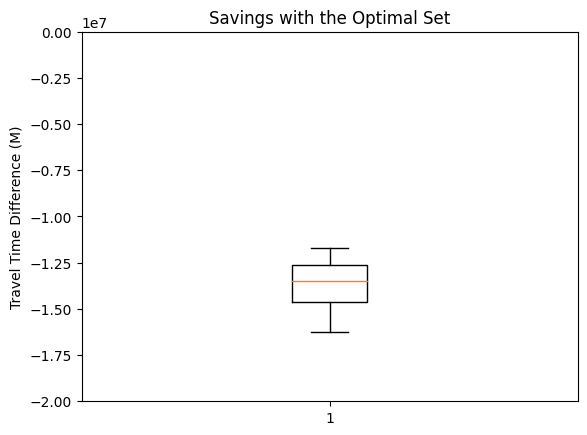

In [41]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.boxplot(test_set['num_steps'].sum() - y)
ax.set(title='Savings with the Optimal Set',
       xlabel='',
       ylabel='Travel Time Difference (M)',
       ylim=(-2*10**7, 0))